<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import torch
  import torchvision
  # check torch 0.12+
  assert(torch.__version__.split('.')[1] >= 12)
  # check torchvision 0.13+
  assert(torchvision.__version__.split('.') >= 13)
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  # install latest torch and torchvision
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 1.13.1+cu117
torchvision version: 0.14.1+cu117


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# import torchinfo or download if necessary
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

# import third party scripts or download from repo if necessary
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    # clone repo
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    # move files from repo to current directory
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    # remove repo -r=recursive, -f=force
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# download third party data and extract to data/pizza_steak_sushi
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [5]:
# store file paths for training and test image folders
train_folder = image_path / "train"
test_folder = image_path / "test"

In [6]:
# transform to resize images to 224 x 224 for ViT and convert to tensor
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [7]:
import os

# create data loaders
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_folder,
                                                                           test_dir=test_folder,
                                                                           transform=transform,
                                                                           batch_size=BATCH_SIZE,
                                                                           num_workers=os.cpu_count())

image shape: torch.Size([3, 224, 224])


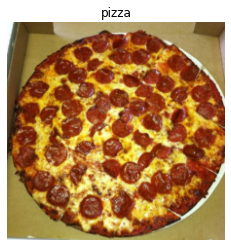

In [8]:
# get next batch of images and labels
batch_images, batch_labels = next(iter(train_dataloader))
# get first image and label from batch
image, label = batch_images[0], batch_labels[0]

# display image and label
print(f"image shape: {image.shape}")
# move color channel for matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False); # semicolon used to supress output in notebooks

### Patch embeddings

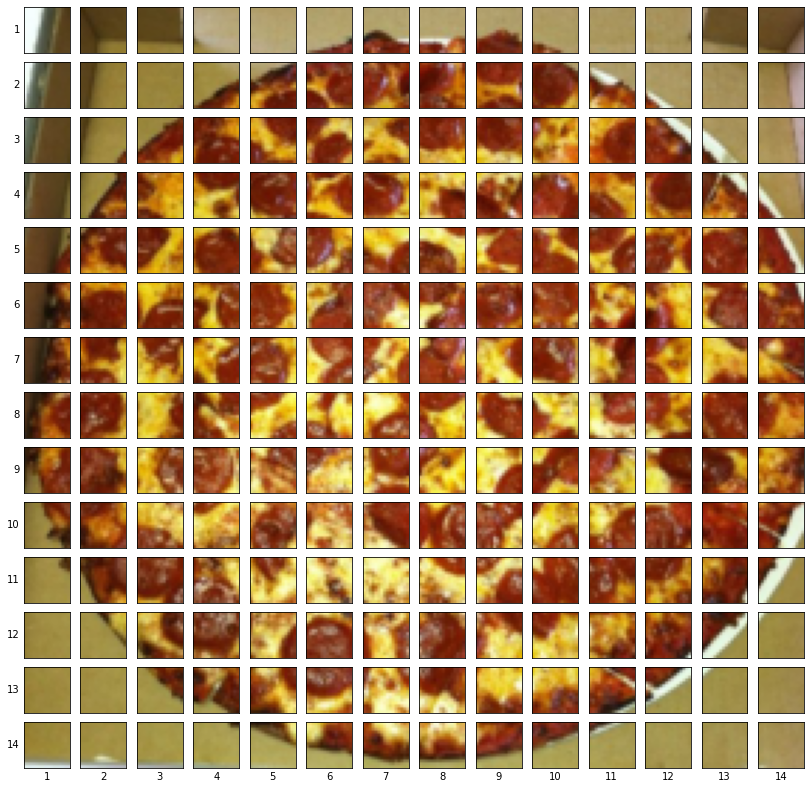

In [9]:
# split image into 16x16 patches

# move color channel for matplotlib
matplot_image = image.permute(1, 2, 0)

# dimensions of image
img_width = 224
img_height = 224
# size of patches
patch_size = 16
# number of patches in width or heght of image
num_patches = 224 / 16
assert(img_width % patch_size == 0)

# subplot for plotting every patch in image
fig, ax = plt.subplots(nrows=img_height // patch_size, ncols=img_width // patch_size, figsize=(num_patches, num_patches), sharex=True, sharey=True)

# for each patch in the height of the image
for i, row_patch in  enumerate(range(0, img_height, patch_size)):
  # for each patch in the row of the image
  for j, col_patch in enumerate(range(0, img_width, patch_size)):
    # add the current patch of the image to the subplot
    ax[i,j].imshow(matplot_image[row_patch:row_patch+patch_size, col_patch:col_patch+patch_size, :])
    # set the position of axes labels
    ax[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center") 
    ax[i, j].set_xlabel(j+1) 
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    # only show labels on the first column and last row of subplots
    ax[i, j].label_outer()

### Convolution layer

convolution output: torch.Size([1, 768, 14, 14])


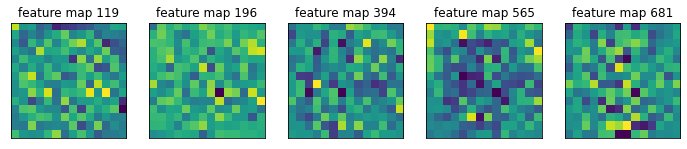

In [31]:
import random

# define convolution layer
layer_1 = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=(patch_size, patch_size), stride=patch_size, padding=0)
# convolve image
feature_map_tensor = layer_1(image.unsqueeze(dim=0))
# convolution output shape
print(f"convolution output: {feature_map_tensor.shape}")

# display 5 random feature maps
rand_idx = random.sample(range(0, 768), k=5)

# set up figure to show the five feature maps
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(rand_idx):
  # display the random feature map from the convolution output
  feature_map = feature_map_tensor[:, idx, :, :]
  ax[i].imshow(feature_map.squeeze().detach().numpy())
  ax[i].set_title(f"feature map {idx}")
  ax[i].set_xticks([])
  ax[i].set_yticks([])


torch.Size([1, 196, 768])


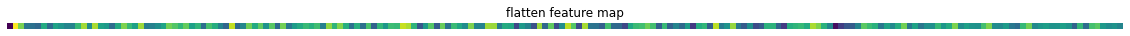

In [32]:
# flatten feature maps
layer_2 = nn.Flatten(start_dim=2, end_dim=3)
feature_map_tensor = layer_2(feature_map_tensor)
# move the feature map dimension
feature_map_tensor = feature_map_tensor.permute(0, 2, 1)

print(feature_map_tensor.shape)

plt.figure(figsize=(20,20))
plt.imshow(feature_map_tensor.detach().numpy()[:, :, 0])
plt.title(f"flatten feature map")
plt.axis(False);

In [37]:
# create custom patch embedding layer

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, embedding_size=768, patch_size=16):
    super(PatchEmbedding, self).__init__()
    self.in_channels = in_channels
    self.embedding_size = embedding_size
    self.patch_size = patch_size
    self.embedding = nn.Sequential(
        nn.Conv2d(in_channels=self.in_channels, out_channels=self.embedding_size, kernel_size=self.patch_size, stride=self.patch_size, padding=0),
        nn.Flatten(start_dim=2, end_dim=3)
    )

  def forward(self, x):
    # check dimension of input
    assert(x.shape[-1] % self.patch_size == 0)
    output = self.embedding(x)
    return output.permute(0, 2, 1)

In [38]:
# apply path embedding layer
embedding_layer = PatchEmbedding()
output = embedding_layer(image.unsqueeze(dim=0))
print(output.shape)

torch.Size([1, 196, 768])
